<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Lo que hicimos...

Empezamos probando LeNet. Sabiamos que el resultado no iba a ser el mejor pero quisimos probar hasta donde podiamos llegar haciendole algunas modificaciones.

Luego de esto decidimos utilizar DenseNet.
Probamos correrla con su arquitectura original y los resultados fueron mucho mejores, notando grandes diferencias simplemente modificando batch_size e image_size

# Librerias y definiciones

In [1]:
!pip install torchinfo

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary
import wandb

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
)

In [3]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import sys
import os

# Configurar límite de memoria MPS para evitar errores de memoria
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [15]:
BATCH_SIZE = 32  # tamaño del batch reducido para evitar problemas de memoria

# Exploracion de datos

## Carga de datos

In [6]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

In [7]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
NUM_CLASES = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

In [16]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")



Clase con MENOS imágenes: n03000684 (859 imágenes)
Clase con MÁS imágenes:  n02979186 (994 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

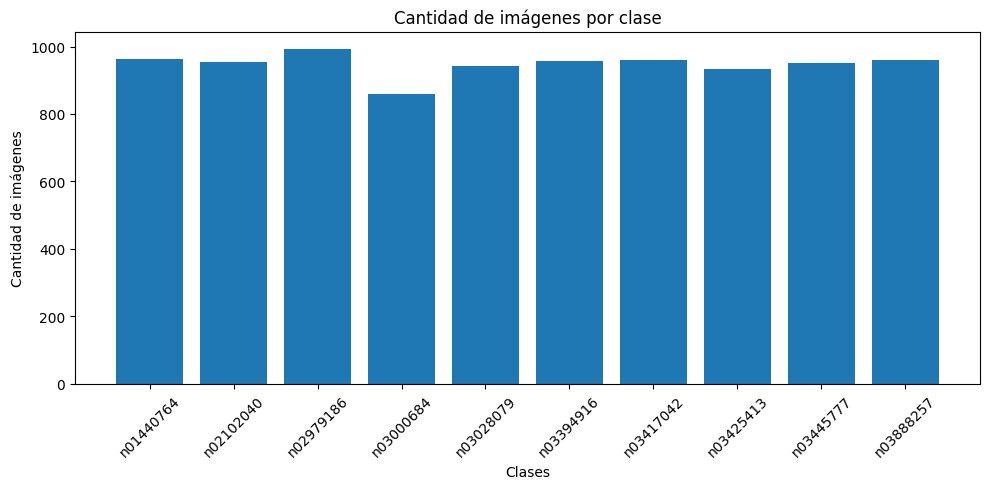

In [17]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

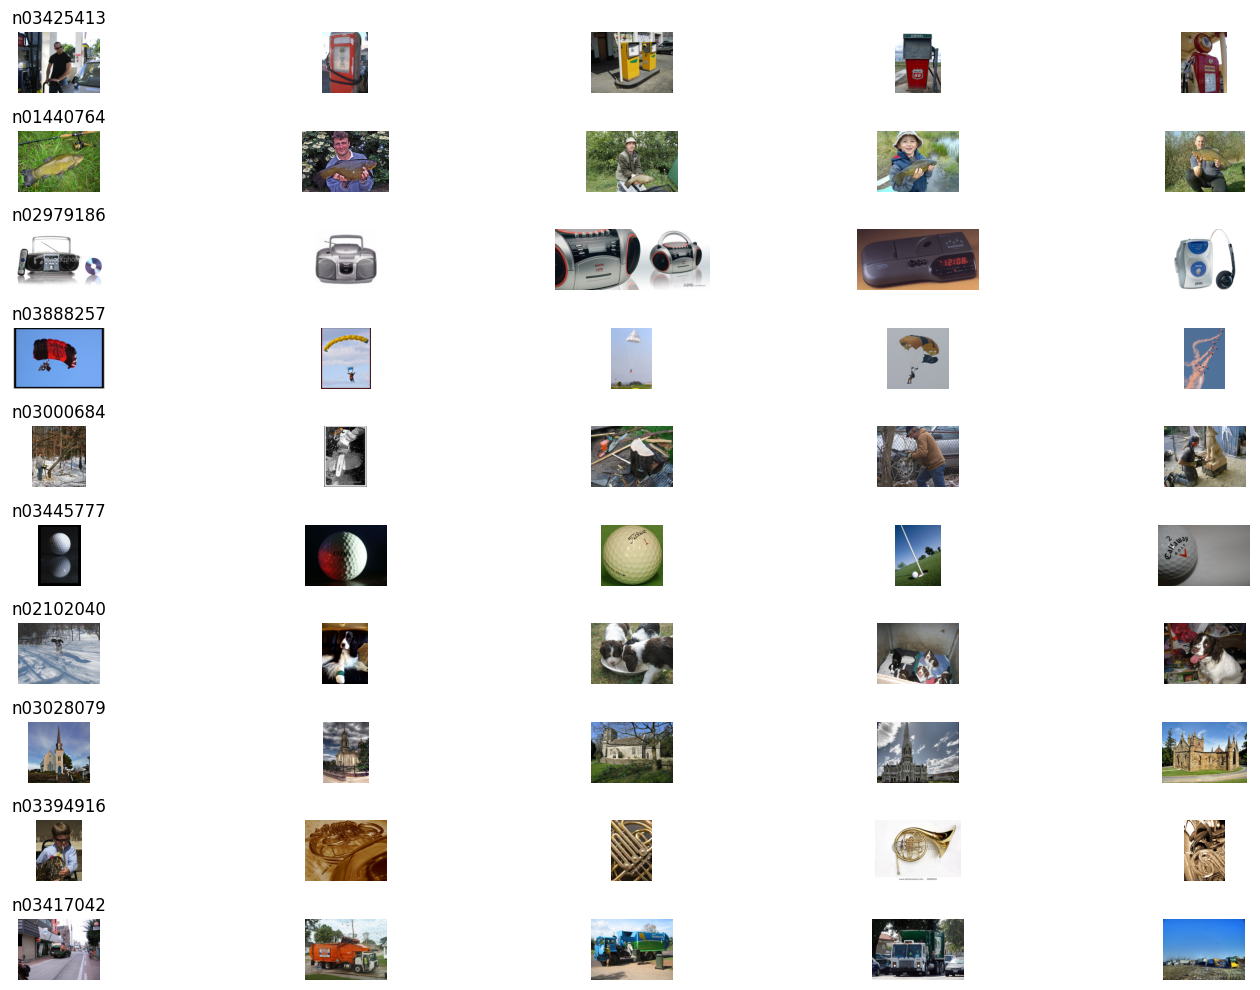

In [18]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [19]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")



Total de tamaños diferentes encontrados: 226
Tamaño MÁS común: (500, 375) (aparece 112 veces)
Tamaño MENOS común: (470, 500) (aparece 1 veces)


## Buscar duplicados

In [21]:
from pathlib import Path
import hashlib

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}

def md5_file(path: Path):
    with path.open("rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []

root = Path(root_dir)
for cls in classes:
    for path in (root/cls).iterdir():
        if not path.is_file() or path.suffix.lower() not in IMG_EXTS or path.name.startswith("."):
            continue
        h = md5_file(path)
        if h in hashes:
            duplicates.append((str(path), hashes[h]))
        else:
            hashes[h] = str(path)

print(f"Encontradas {len(duplicates)} imágenes duplicadas.")

Encontradas 0 imágenes duplicadas.


## Conclusión de la exploracion de datos

Del análisis anterior podemos observar que las clases se encuentran balanceadas, ya que cada una posee un número similar de imágenes. Además, verificamos que no existen duplicados, por lo que no es necesario eliminar ninguna imagen. Finalmente, notamos que las imágenes presentan distintas dimensiones, por lo que es necesario aplicar un proceso de resize para garantizar la consistencia del conjunto de datos.

# Pruebas con transformaciones

Con el objetivo de entender qué transformaciones aplicar a las imagenes para ayudar al modelo a interpretarlas mejor, hicimos las siguientes pruebas:

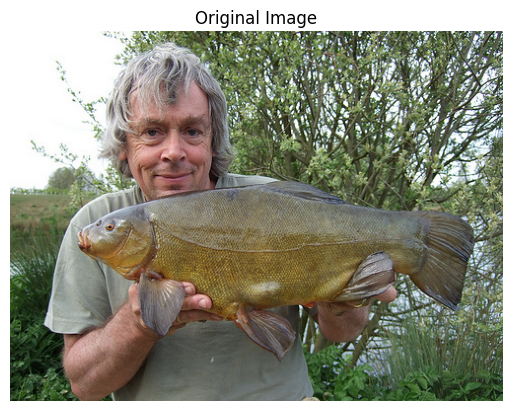

In [22]:
img = read_image(str(Path("data/imagenette2/train/n01440764/ILSVRC2012_val_00011993.JPEG")))
show_tensor_image(img, title="Original Image")

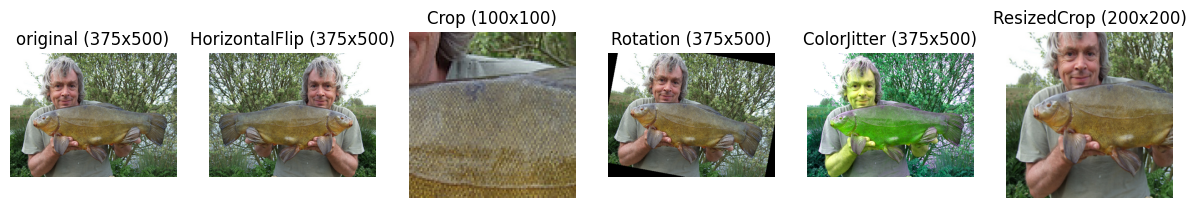

In [23]:
img_rhf = T.RandomHorizontalFlip(p=1)(img)  # p=1 para que siempre se aplique
img_rc = T.RandomCrop(size=(100, 100))(img)  # tomamos un recorte de 100x100
img_rr = T.RandomRotation(degrees=45)(
    img
)  # rotamos la imagen de forma aleatoria entre -45 y 45 grados
img_cj = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)(
    img
)  # aplicamos un cambio de color
img_rrc = T.RandomResizedCrop(size=(200, 200))(
    img
)  # tomamos un recorte y redimensionamos a 200x200

show_tensor_images(
    [img, img_rhf, img_rc, img_rr, img_cj, img_rrc],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"HorizontalFlip ({img_rhf.shape[-2]}x{img_rhf.shape[-1]})",
        f"Crop ({img_rc.shape[-2]}x{img_rc.shape[-1]})",
        f"Rotation ({img_rr.shape[-2]}x{img_rr.shape[-1]})",
        f"ColorJitter ({img_cj.shape[-2]}x{img_cj.shape[-1]})",
        f"ResizedCrop ({img_rrc.shape[-2]}x{img_rrc.shape[-1]})",
    ],
)

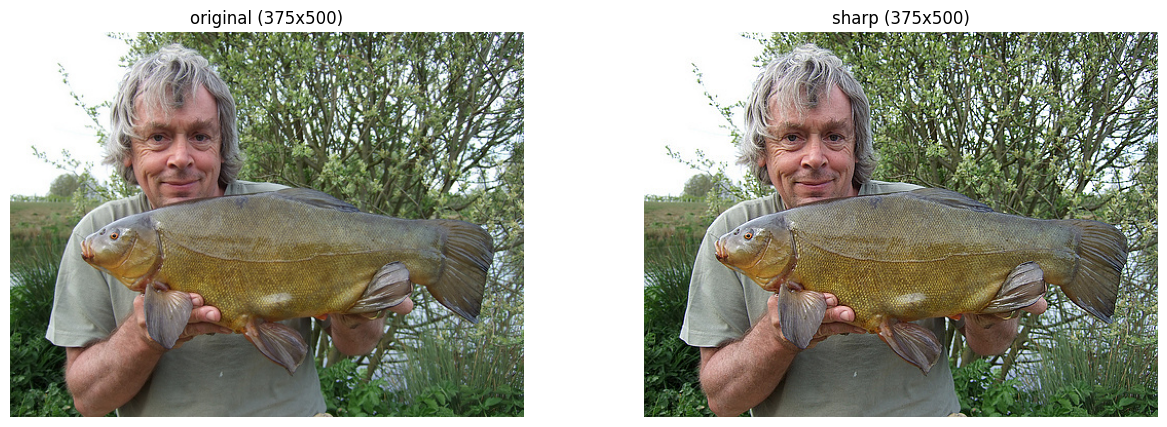

In [24]:
img_sharp = T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)(img)
img_sharp = T.RandomEqualize(p=0.3)(img_sharp)
img_sharp = T.RandomAutocontrast(p=0.3)(img_sharp)

show_tensor_images(
    [img, img_sharp],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"sharp ({img_sharp.shape[-2]}x{img_sharp.shape[-1]})"
    ]
)

In [ ]:
img_size_test = 128
# ---------- SHAPE ----------
img_shape = T.ToImage()(img)
# img_shape = T.Grayscale(num_output_channels=1)(img_shape)
img_shape = T.RandomHorizontalFlip(p=0.5)(img_shape)
img_shape = T.RandomResizedCrop(img_size_test, scale=(0.7, 1.0))(img_shape)
img_shape = T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))(img_shape)
img_shape = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))(img_shape)   # suaviza textura
img_shape = T.RandomPosterize(bits=4, p=0.3)(img_shape)                   # reduce detalle
img_shape = T.RandomAutocontrast(p=0.3)(img_shape)
img_shape = T.ToDtype(torch.float32, scale=True)(img_shape)

# ---------- TEXTURE ----------
img_tex = T.ToImage()(img)                                               # mantiene RGB
img_tex = T.RandomResizedCrop(img_size_test, scale=(0.7, 1.0))(img_tex)
img_tex = T.RandomHorizontalFlip(p=0.5)(img_tex)
img_tex = T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05)(img_tex)
img_tex = T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)(img_tex)   # realza bordes/tex
img_tex = T.RandomAutocontrast(p=0.3)(img_tex)
img_tex = T.ToDtype(torch.float32, scale=True)(img_tex)


show_tensor_images(
    [T.ToDtype(torch.float32, scale=True)(T.ToImage()(img)), img_shape, img_tex],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"shape_aug ({img_shape.shape[-2]}x{img_shape.shape[-1]})",
        f"texture_aug ({img_tex.shape[-2]}x{img_tex.shape[-1]})",
    ],
)


# LeNet

## Definiciones

In [28]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [29]:
IMG_SIZE = 128  # Reducir tamaño de imagen para ahorrar memoria

In [30]:
val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToDtype(torch.float32, scale=True),
])

In [31]:
train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=False, transform=val_tfms_lenet
) 

# Stack todas las imágenes en un tensor
data = torch.stack([img for img, _ in train_dataset])
# Shape: (50000, 3, 32, 32)

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

Mean: tensor([0.4625, 0.4580, 0.4295])
Std: tensor([0.2769, 0.2730, 0.2967])


In [32]:
train_tfms_lenet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


## Regularization

Aplicamos transformaciones sobre train, algunas de ellas para data augmentation, como ser RandomHorizontalFlip y RandomRotation. 

En el training loop aplicamos early stopping probando con distintos valores de paciencia y además agregamos una capa de dropout antes de la salida.

## Arquitectura del modelo

La arquitectura original de Lenet fue modificada para soportar imagenes de 3 canales

Se agregó AdaptiveAvgPool2d((1,1)): ahora la salida conv se comprime a 1×1 sin importar el tamaño de entrada (más flexible).

Se cambió Linear(120, 84) por LazyLinear(84): la red infiere automáticamente cuántas features entran a la capa densa (evita recalcular a mano)

Consecuencia: la versión nueva (flexible) soporta entradas que no sean 32×32 y cambios en kernels/strides sin romper dimensiones; la clásica asume 32×32 y que el último conv termine en 1×1.

In [34]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        super(LeNet, self).__init__()
        self.use_dropout = use_dropout
        self.dropout_p = dropout_p

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)  
        self.pool  = nn.AvgPool2d(kernel_size=2, stride=2)                                                   # /2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)           
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)        
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # reemplaza al AvgPool2d(28,28)

        self.tanh = nn.Tanh()
        self.linear = nn.LazyLinear(84)   # en vez de nn.Linear(120, 84)

        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()

    def forward(self, x):
        # x: [B, C=3, 140, 140]
        x = self.tanh(self.conv1(x))
        x = self.pool(x) 
        x = self.tanh(self.conv2(x)) 
        x = self.pool(x)             
        x = self.tanh(self.conv3(x)) 
        x = self.pool3(x)            
        x = self.flatten(x)          
        x = self.tanh(self.linear(x))
        x = self.dropout(x)
        x = self.output(x)           
        return x


summary(LeNet(3, NUM_CLASES), input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 124, 124]         456
├─Tanh: 1-2                              [32, 6, 124, 124]         --
├─AvgPool2d: 1-3                         [32, 6, 62, 62]           --
├─Conv2d: 1-4                            [32, 16, 58, 58]          2,416
├─Tanh: 1-5                              [32, 16, 58, 58]          --
├─AvgPool2d: 1-6                         [32, 16, 29, 29]          --
├─Conv2d: 1-7                            [32, 120, 25, 25]         48,120
├─Tanh: 1-8                              [32, 120, 25, 25]         --
├─AdaptiveAvgPool2d: 1-9                 [32, 120, 1, 1]           --
├─Flatten: 1-10                          [32, 120]                 --
├─Linear: 1-11                           [32, 84]                  10,164
├─Tanh: 1-12                             [32, 84]                  --
├─I

## Entrenamiento


In [35]:
LR = 0.001
EPOCHS = 100
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [ ]:
letnet_model = LeNet(3, NUM_CLASES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)


epoch_train_errors, epoch_val_errors = train(
    letnet_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    do_early_stopping=True,
    patience=10,
    epochs=EPOCHS,
    log_fn=print_log,
    log_every=1,
)

In [ ]:
plot_training(epoch_train_errors, epoch_val_errors)

In [ ]:
model_classification_report(letnet_model, val_loader, DEVICE, NUM_CLASES)

## Weight & Biases

En wandb probamos varia distintos parámetros del problema para luego ver qué combinación nos da el mejor resultado.

In [37]:
WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_3"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

wandb: Currently logged in as: mc241319 (mc-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
sweep_config = {
    "name": "tarea_1_lenet_memory_optimized",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data 
        "batch_size": {"values": [32, 64, 128]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [4, 6]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

In [ ]:
entity = wandb.api.default_entity
project = WANDB_PROJECT

print("Entity actual:", entity)
print("Project actual:", project)

In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [ ]:
import time 

accuracies = []
precisions = []
recalls = []
f1_scores = []
supports = []

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing


    # modelo
    if run_dropout_p == 0:
        model = LeNet(3, NUM_CLASES).to(DEVICE)
    else:
        model = LeNet(3, NUM_CLASES, True, run_dropout_p).to(DEVICE)

    # dataloaders  
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, run_batch_size, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 10 == 0:
            wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)        

    train(model, optimizer, criterion, train_loader, val_loader, device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
          epochs=EPOCHS, log_fn=log_with_timing, log_every=1)
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    accuracy, precision, recall, f1score, support = model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1score)
    supports.append(support)


    wandb.finish()
    



In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

## Evaluación final tomando mejor modelo

In [ ]:
# Crear un bar chart que compare los resultados de los sweeps
import matplotlib.pyplot as plt
import numpy as np

# Obtener todos los runs del sweep
api = wandb.Api()
ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

# Extraer datos de todos los runs
runs = []
run_names = []

for run in sweep.runs:
    if run.state == "finished":  # Solo runs completados
        runs.append(run)
        run_names.append(run.name)

# Crear subplots para mostrar todas las métricas
# fig, axes = plt.subplots(2, 2, figsize=(20, 12))
# fig.suptitle('Métricas de Rendimiento por Sweep Run', fontsize=16, fontweight='bold')

# Configurar colores para cada métrica
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
metrics = [accuracies, precisions, recalls, f1_scores]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
y_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Crear gráfico combinado (manteniendo tu lógica)
x = np.arange(len(run_names))  # posiciones de las barras por modelo
width = 0.2  # ancho de cada barra

# Crear figura
fig, ax = plt.subplots(figsize=(14, 5))

# Dibujar cada métrica desplazada
for i, metric in enumerate(metrics):
    if len(metric) != len(run_names):
        print(f"⚠️ Longitud de {metric_names[i]} ({len(metric)}) no coincide con run_names ({len(run_names)}). Se omite.")
        continue
    ax.bar(x + i*width, metric, width, label=metric_names[i], color=colors[i])

# Personalización
ax.set_xlabel("Modelos")
ax.set_ylabel("Puntaje")
ax.set_title("Comparación de Métricas por Modelo")
ax.set_xticks(x + width * (len(metrics)-1)/2)
ax.set_xticklabels(run_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar
plt.tight_layout()
plt.show()

# Mostrar información adicional
print(f"\n=== RESUMEN DE MÉTRICAS ===")
print(f"Total de runs completados: {len(run_names)}")
print(f"\n--- Accuracy ---")
maxArg = np.argmax(accuracies)
print(f"Mejor: {run_names[maxArg]} {accuracies[maxArg]:.4f}")

print(f"\n--- Precision ---")
maxArg = np.argmax(precisions)
print(f"Mejor: {run_names[maxArg]} {precisions[maxArg]:.4f}")

print(f"\n--- Recall ---")
maxArg = np.argmax(recalls)
print(f"Mejor: {run_names[maxArg]} {recalls[maxArg]:.4f}")


print(f"\n--- F1-Score ---")
maxArg = np.argmax(f1_scores)
print(f"Mejor: {run_names[maxArg]} {f1_scores[maxArg]:.4f}")

# Mostrar tabla de resultados
# print(f"\n=== TABLA DE RESULTADOS ===")
# print(f"{'Run Name':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
# print("-" * 70)
# for i, name in enumerate(run_names):
#     print(f"{name:<20} {accuracies[i]:<10.4f} {precisions[i]:<10.4f} {recalls[i]:<10.4f} {f1_scores[i]:<10.4f}")




In [ ]:
api = wandb.Api()

# ULTIMA CORRIDA
# Create sweep with ID: da8kuc8y
# Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_3/sweeps/da8kuc8y

ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

# nos traemos el sweep (objeto) para analizar los resultados
# sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")
 
# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print("best run:", best_run)
# print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")
# print("Best run metrics:", best_run.summary)

print("Best run name:", best_run.name)
print("Best run name:", best_run.id)
print("Best run config:", best_run.config)

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

In [ ]:
import json

s = best_run.summary_metrics  # o best_run.summary
if isinstance(s, dict):
    val_loss = s.get("val_loss")
elif isinstance(s, str):
    val_loss = json.loads(s).get("val_loss")
else:
    # fallback por si W&B lo envuelve en un objeto raro
    val_loss = getattr(s, "get", lambda *_: None)("val_loss")

print("val_loss:", val_loss)

In [ ]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

In [ ]:

criterion = nn.CrossEntropyLoss().to(DEVICE)

# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

In [ ]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

In [ ]:
import wandb, json

api = wandb.Api()

ENTITY = api.default_entity  # usá el entity correcto según tu URL
RUN_ID  = "4n4q5wiq"               # <- el run que querés

# 1) Traer el run por path
run_path = f"{ENTITY}/{WANDB_PROJECT}/{RUN_ID}"
run = api.run(run_path)

print("RUN:", run.id, "| name:", run.name)
print("URL:", run.url)
print("STATE:", run.state)
print("CONFIG:", dict(run.config))

# 2) Leer summary de forma segura (algunas versiones lo devuelven como string)
def summary_dict(r):
    s = getattr(r, "summary_metrics", None)
    if isinstance(s, str):
        try:
            return json.loads(s)
        except Exception:
            return {}
    if isinstance(s, dict):
        return s
    # fallback para r.summary con wrapper antiguo
    s2 = getattr(getattr(r, "summary", {}), "_json_dict", {})
    if isinstance(s2, dict):
        return s2
    return {}

summary = summary_dict(run)
print("SUMMARY KEYS:", [k for k in summary.keys() if not k.startswith("_")])
print("val_loss:", summary.get("val_loss"))

# 3) Descargar el modelo de ese run
#    Si el archivo exacto no existe, listá los .pth disponibles.
try:
    run.file("model.pth").download(replace=True)
    print("Descargado: model.pth")
except Exception as e:
    print("No encontré model.pth directamente:", e)
    print("Buscando .pth disponibles en el run...")
    pth_files = [f for f in run.files() if f.name.endswith(".pth")]
    for f in pth_files:
        print("->", f.name, f.size)
    if pth_files:
        pth_files[0].download(replace=True)
        print("Descargado:", pth_files[0].name)
    else:
        print("No hay archivos .pth en este run.")


In [ ]:
letnet_model.load_state_dict(torch.load("model.pth"))

In [ ]:
def getValue(data, value_name):
    if isinstance(data, dict):
        value = data.get(value_name)
    elif isinstance(data, str):
        value = json.loads(data).get(value_name)
    else:
        # fallback por si W&B lo envuelve en un objeto raro
        value = getattr(data, "get", lambda *_: None)(value_name)

    print("val_loss:", val_loss)
    return value

In [ ]:

criterion = nn.CrossEntropyLoss().to(DEVICE)

# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
   
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

In [ ]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

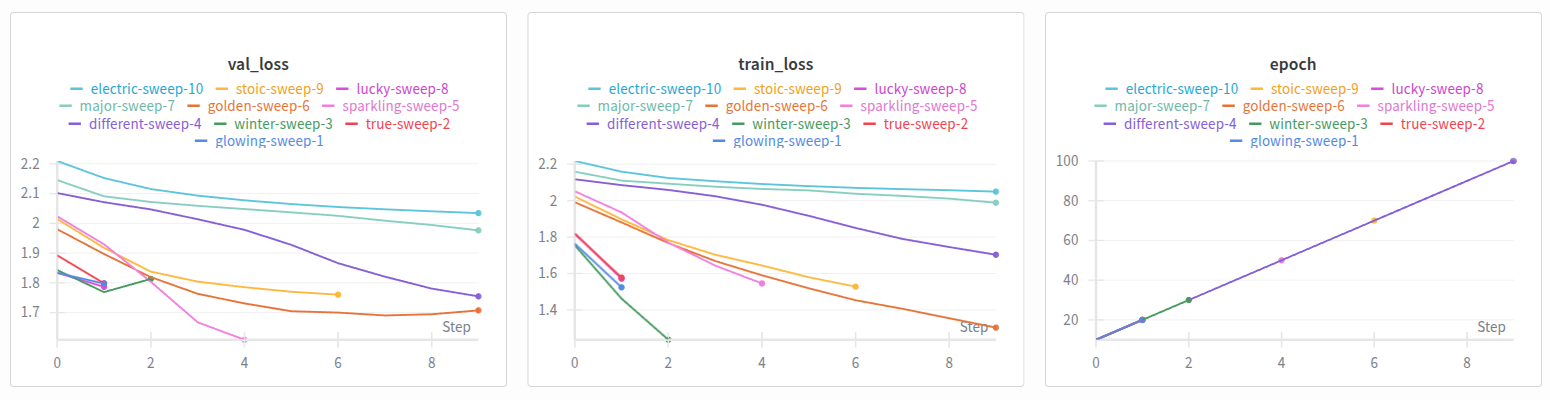

## Conclusión de los datos

# DenseNet


## Definiciones

In [38]:
IMG_SIZE = 128 # image size lo mas grande posible para tener mas resolucion
BATCH_SIZE = 32

## Arquitectura

In [39]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

In [40]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [41]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = self.conv(self.bn(x))
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

In [42]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)
        self.dropout_p = dropout_p

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación con dropout
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(p=dropout_p) if dropout_p > 0 else nn.Identity()
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.dropout(x)  # Aplicar dropout antes de la capa final
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                            [32, 64, 128, 128]        128
├─ReLU: 1-3                                   [32, 64, 128, 128]        --
├─Sequential: 1-4                             [32, 1024, 16, 16]        --
│    └─DenseBlock: 2-1                        [32, 256, 128, 128]       --
│    │    └─Sequential: 3-1                   [32, 256, 128, 128]       250,752
│    └─TransitionLayer: 2-2                   [32, 128, 64, 64]         --
│    │    └─BatchNorm2d: 3-2                  [32, 256, 128, 128]       512
│    │    └─ReLU: 3-3                         [32, 256, 128, 128]       --
│    │    └─Conv2d: 3-4                       [32, 128, 128, 128]       32,896
│    │    └─AvgPool2d: 3-5                    [32, 128, 64, 64]         --
│    └

## Carga de datos con transforms

In [43]:
def get_train_tfms_densenet(image_size=IMG_SIZE, transform_shape=True, transform_texture=True):
    transforms = [
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((image_size, image_size), antialias=True),

        # Geométricas
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=10),
        T.RandomResizedCrop((image_size, image_size), scale=(0.8, 1.0), antialias=True),
        T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),

        T.RandomAutocontrast(p=0.3)
    ]
   
    if transform_shape:
        transforms += [
            T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            T.RandomEqualize(p=0.3),
            T.RandomPosterize(bits=4, p=0.3)
        ]
        
    if transform_texture: 
        transforms += [
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
            T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)
           
        ]
    
    
    transforms += [
        T.Normalize(mean=T_MEAN, std=T_STD),
    ]

    train_transforms = T.Compose(transforms)
    
    val_transforms = T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((image_size, image_size), antialias=True),
        T.Normalize(mean=T_MEAN, std=T_STD),
    ])
    
    return train_transforms, val_transforms


In [44]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

In [ ]:
train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

## Entrenamiento DenseNet con cosine decay

Definimos la función train_cosine_decay, que es igual a la train que venimos usando, pero agrega cosine decay para manejar el valor del learning rate.
Lo que hace esto es ajustar el learning rate schedule para mejorar la convergencia. La idea es probar en Weight and Bias si el modelo converge más rápido y si trae alguna otra mejora, al tomar learning rate de esta manera.

En esta sección probamos una corrida manual para verificar que el resultado no empeore.


In [46]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_cosine_decay(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    do_early_stopping=True,
    patience=5,
    epochs=10,
    log_fn=print_log,
    log_every=1,
    eta_min=1e-6,
):
    """
    Entrena el modelo utilizando Cosine Decay (CosineAnnealingLR) para el learning rate.
    """

    epoch_train_errors = []
    epoch_val_errors = []

    if do_early_stopping:
        early_stopping = EarlyStopping(patience=patience)

    # Scheduler Cosine Decay
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            
            output = model(x)
            batch_loss = criterion(output, y)
            
            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item()

        train_loss /= len(train_loader)
        epoch_train_errors.append(train_loss)

        val_loss = evaluate(model, criterion, val_loader, device)
        epoch_val_errors.append(val_loss)

        # Step del scheduler (una vez por epoch)
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        if do_early_stopping:
            early_stopping(val_loss)

        if log_fn is not None and (epoch + 1) % log_every == 0:
            log_fn(epoch, train_loss, val_loss)
            print(f"[EPOCH {epoch+1}] lr={current_lr:.6e} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

        if do_early_stopping and early_stopping.early_stop:
            print(f"⏹ Detener entrenamiento en la época {epoch+1}, mejor val_loss={early_stopping.best_score:.5f}")
            break

    return epoch_train_errors, epoch_val_errors


In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

train_errors_dn, val_errors_dn = train_cosine_decay(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

## Weight & Biases

A los parámetros habituales del sweep agregamos:

- growth_rate          --> modificamos cuánta información pasa de una capa a la otra
- num_layers           --> queremos comparar entre redes "chicas" y "grandes", cuál da mejor resultado
- use_cosine_annealing --> True para cosine decay, False para tomar learning rate de log_uniform_values
- cosine_eta_min       --> Valor mas bajo que alcanza el LR sobre el final del entrenamiento
- transform_shape      --> Si es True, aplica transforms a train que resaltan las formas en la imagen
- transform_texture    --> Si es True, aplica transforms a train que realtan la textura de la imagen

In [47]:
# Sweep configuration for DenseNet
sweep_config_densenet = {
    "name": "tarea_1_densenet_sweep",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},
    "parameters": {
        # Optimizer and learning parameters
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4, 1e-3]},
        
        # Training parameters
        "batch_size": {"values": [16, 32]},
        "early_stop": {"values": [True, False]},
        "patience": {"values": [5, 8, 10, 15]},
        "label_smoothing": {"values": [0.0, 0.05, 0.1]},
        
        # DenseNet specific parameters
        "growth_rate": {"values": [16, 24, 32]},
        "num_layers": {
            "values": [
                [4, 6, 8, 6],     # Smaller version
                [6, 12, 24, 16],  # DenseNet-121 original
                # [6, 12, 32, 32],  # DenseNet-169 style
                [6, 12, 48, 32],  # DenseNet-201 style
                # [8, 16, 24, 12],  # Medium version
            ]
        },
        
        # Scheduler options
        "use_cosine_annealing": {"values": [True, False]},
        "cosine_eta_min": {"values": [1e-6, 1e-5, 1e-4]},
        
        # Regularization
        "dropout_p": {"values": [0.0, 0.1, 0.2, 0.3]},
        "transform_shape": {"values": [True, False]},
        "transform_texture": {"values": [True, False]},
    },
}

print("DenseNet Sweep Configuration:")
print(f"Total parameter combinations: {len(sweep_config_densenet['parameters'])} parameters")
for param, config in sweep_config_densenet['parameters'].items():
    if 'values' in config:
        print(f"  {param}: {len(config['values'])} options")
    elif 'distribution' in config:
        print(f"  {param}: {config['distribution']} distribution")


DenseNet Sweep Configuration:
Total parameter combinations: 14 parameters
  optimizer: 2 options
  learning_rate: log_uniform_values distribution
  weight_decay: 4 options
  batch_size: 2 options
  early_stop: 2 options
  patience: 4 options
  label_smoothing: 3 options
  growth_rate: 3 options
  num_layers: 3 options
  use_cosine_annealing: 2 options
  cosine_eta_min: 3 options
  dropout_p: 4 options
  transform_shape: 2 options
  transform_texture: 2 options


In [48]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
supports = []

def densenet_sweep_run():
    """
    Función que se ejecutará en cada run del sweep para DenseNet.
    """
    # Inicializar un nuevo run
    wandb.init()
    
    # Leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing
    run_growth_rate = config.growth_rate
    run_num_layers = config.num_layers
    run_use_cosine_annealing = config.use_cosine_annealing
    run_cosine_eta_min = config.cosine_eta_min
    run_dropout_p = config.dropout_p
    run_transform_shape = config.transform_shape
    run_transform_texture = config.transform_texture

    # Crear modelo DenseNet
    model = DenseNet(
        num_layers=run_num_layers,
        growth_rate=run_growth_rate,
        num_classes=NUM_CLASES,
        dropout_p=run_dropout_p
    ).to(DEVICE)

    # Crear dataloaders
    train_tfms_densenet, val_tfms_densenet = get_train_tfms_densenet(64, run_transform_shape, run_transform_texture)
    train_loader, val_loader, test_loader = get_dataloaders(
        train_tfms_densenet, val_tfms_densenet, run_batch_size, NUM_WORKERS
    )

    # Crear optimizer
    if run_optimizer == "adam":
        optimizer = optim.Adam(
            model.parameters(), 
            lr=run_learning_rate, 
            weight_decay=run_weight_decay
        )
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), 
            lr=run_learning_rate, 
            momentum=0.9, 
            nesterov=True, 
            weight_decay=run_weight_decay
        )

    # Crear criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 5 == 0:  # Log cada 5 épocas
            wandb.log({
                "epoch": epoch+1, 
                "train_loss": train_loss, 
                "val_loss": val_loss
            })
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)

    # Entrenar modelo
    if run_use_cosine_annealing:
        train_cosine_decay(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            device=DEVICE,
            do_early_stopping=run_early_stopping,
            patience=run_patience,
            epochs=EPOCHS,
            log_fn=log_with_timing,
            log_every=1,
            eta_min=run_cosine_eta_min,
        )
    else:
        train(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            device=DEVICE,
            do_early_stopping=run_early_stopping,
            patience=run_patience,
            epochs=EPOCHS,
            log_fn=log_with_timing,
            log_every=1,
        )
    
    # Guardar pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save("model.pth")

    # Evaluar modelo
    accuracy, precision, recall, f1score, support = model_classification_report(
        model, test_loader, DEVICE, NUM_CLASES
    )

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1score)
    supports.append(support)

    wandb.finish()


In [49]:
# Crear y ejecutar el sweep de DenseNet
WANDB_PROJECT_DENSENET = "Tarea1_DenseNet"

# Crear el sweep
sweep_id_densenet = wandb.sweep(sweep_config_densenet, project=WANDB_PROJECT_DENSENET)

print(f"DenseNet Sweep creado con ID: {sweep_id_densenet}")


Create sweep with ID: qo7wrja1
Sweep URL: https://wandb.ai/mc-ort/Tarea1_DenseNet/sweeps/qo7wrja1
DenseNet Sweep creado con ID: qo7wrja1


In [ ]:
wandb.agent(sweep_id_densenet, function=densenet_sweep_run, count=15)

wandb: Agent Starting Run: s6bicozz with config:
wandb: 	batch_size: 32
wandb: 	cosine_eta_min: 1e-06
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	growth_rate: 24
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.004293368747033131
wandb: 	num_layers: [6, 12, 48, 32]
wandb: 	optimizer: sgd
wandb: 	patience: 10
wandb: 	transform_shape: True
wandb: 	transform_texture: True
wandb: 	use_cosine_annealing: True
wandb: 	weight_decay: 0.0001


[EPOCH 1] lr=4.292310e-03 train_loss=2.0478 val_loss=1.7194
[EPOCH 2] lr=4.289134e-03 train_loss=1.7811 val_loss=1.5309
[EPOCH 3] lr=4.283844e-03 train_loss=1.6546 val_loss=1.4377
[EPOCH 4] lr=4.276445e-03 train_loss=1.5094 val_loss=1.2012
[EPOCH 5] train_loss=1.4101 val_loss=1.2118
[EPOCH 5] lr=4.266946e-03 train_loss=1.4101 val_loss=1.2118
[EPOCH 6] lr=4.255354e-03 train_loss=1.3399 val_loss=1.2496
[EPOCH 7] lr=4.241682e-03 train_loss=1.2564 val_loss=1.0383
[EPOCH 8] lr=4.225942e-03 train_loss=1.2288 val_loss=1.3139
[EPOCH 9] lr=4.208152e-03 train_loss=1.1844 val_loss=0.9328
[EPOCH 10] train_loss=1.1393 val_loss=1.0236
[EPOCH 10] lr=4.188327e-03 train_loss=1.1393 val_loss=1.0236
[EPOCH 11] lr=4.166488e-03 train_loss=1.0914 val_loss=1.0713
[EPOCH 12] lr=4.142656e-03 train_loss=1.0490 val_loss=0.8551
[EPOCH 13] lr=4.116855e-03 train_loss=1.0228 val_loss=1.0943
[EPOCH 14] lr=4.089110e-03 train_loss=0.9924 val_loss=0.8674
[EPOCH 15] train_loss=0.9465 val_loss=0.8239
[EPOCH 15] lr=4.05944

## Conclusión de los datos

# Comparación de todos los modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.